In [1]:
import pandas as pd
from ast import literal_eval
import nltk
import re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
!pip freeze | grep scipy

scipy==1.10.1


# Load Datasets

We load the preprocessed datasets. Make sure to run the previous notebooks first, so the files are present.

## media

In [3]:
df_media = pd.read_csv('../data/cleantech-media.csv', converters={"token_content": literal_eval}, parse_dates=['date'])
df_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9588 entries, 0 to 9587
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          9588 non-null   object        
 1   date           9588 non-null   datetime64[ns]
 2   author         31 non-null     object        
 3   content        9588 non-null   object        
 4   domain         9588 non-null   object        
 5   url            9588 non-null   object        
 6   token_content  9588 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 524.5+ KB


In [4]:
df_media.head(5)

,title,date,author,content,domain,url,token_content
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,Qatar Petroleum ( QP) is targeting aggressive ...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[qatar, petroleum, qp, target, aggress, cut, g..."
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,Nuclear Power Corp. of India Ltd. ( NPCIL) syn...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[nuclear, power, corp, india, ltd, npcil, sync..."
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,New US President Joe Biden took office this we...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[new, us, presid, joe, biden, take, offic, wee..."
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,The slow pace of Japanese reactor restarts con...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[slow, pace, japanes, reactor, restart, contin..."
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,Two of New York City's largest pension funds s...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[two, new, york, citi, larg, pension, fund, sa..."


## patents

In [5]:
df_patents = pd.read_csv('../data/google_patents.csv', converters={"token_content": literal_eval}, parse_dates=['publication_date'])
df_patents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13199 entries, 0 to 13198
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publication_number  13199 non-null  object        
 1   application_number  13199 non-null  object        
 2   country_code        13199 non-null  object        
 3   publication_date    13199 non-null  datetime64[ns]
 4   inventor            13199 non-null  object        
 5   title               13199 non-null  object        
 6   abstract            13199 non-null  object        
 7   abstract_lang       13199 non-null  object        
 8   token_content       13199 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 928.2+ KB


In [6]:
df_patents.head()

,publication_number,application_number,country_code,publication_date,inventor,title,abstract,abstract_lang,token_content
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,['en'],"[disclos, adapt, dc, ac, invert, system, oper,..."
1,US-2022239251-A1,US-202217580956-A,US,2022-07-28,[],System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",['en'],"[accord, exampl, embodi, solar, energi, system..."
2,US-11396827-B2,US-202117606042-A,US,2022-07-26,[],Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,['en'],"[control, method, optim, solar, power, effici,..."
3,CN-114772674-A,CN-202210500131-A,CN,2022-07-22,[],Low-carbon running saline wastewater treatment...,The invention discloses a system and a method ...,"['zh', 'en']","[invent, disclos, system, method, treat, low, ..."
4,CN-217026795-U,CN-202220668705-U,CN,2022-07-22,[],Water ecological remediation device convenient...,The utility model discloses a water ecological...,"['zh', 'en']","[util, model, disclos, water, ecolog, restor, ..."


# Pre-processing

Mostly taken form previous notebook, but without lemmatizing/stemming.

In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_nltk = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pascal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_text(text):

    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]+', '', text)

    # tokenize the text
    re_tokens = re.findall('[\w]+', text)

    # remove stopwords
    filtered_stopwords = []
    for word in re_tokens:
        if word.lower() not in stop_words_nltk:
            filtered_stopwords.append(word.lower())
        else:
            pass

    return filtered_stopwords

preprocess_text('This, my Friend, is a % test. Have I passed?')

['friend', 'test', 'passed']

In [9]:
%%time 
media_tokens = df_media['content'].apply(lambda x: preprocess_text(x))

CPU times: user 7.68 s, sys: 58.4 ms, total: 7.74 s
Wall time: 7.76 s


In [10]:
media_tokens[:10]

0    [qatar, petroleum, qp, targeting, aggressive, ...
1    [nuclear, power, corp, india, ltd, npcil, sync...
2    [new, us, president, joe, biden, took, office,...
3    [slow, pace, japanese, reactor, restarts, cont...
4    [two, new, york, citys, largest, pension, fund...
5    [japans, supreme, court, likely, become, arbit...
6    [oil, natural, gas, industry, officials, looki...
7    [new, great, game, emerging, energy, business,...
8    [close, th, anniversary, fukushima, daiichi, d...
9    [coldest, weather, generation, brought, widesp...
Name: content, dtype: object

In [11]:
# number of words
len([word for sublist in media_tokens for word in sublist])

4314610

In [12]:
# number of unique words
len(set([word for sublist in media_tokens for word in sublist]))

87078

In [13]:
%%time
patent_tokens = df_patents['abstract'].apply(lambda x: preprocess_text(x))

CPU times: user 2.75 s, sys: 22.7 ms, total: 2.77 s
Wall time: 2.77 s


In [14]:
patent_tokens[:10]

0    [disclosed, adaptable, dcac, inverter, system,...
1    [accordance, example, embodiment, solar, energ...
2    [control, method, optimizing, solartopower, ef...
3    [invention, discloses, system, method, treatin...
4    [utility, model, discloses, water, ecological,...
5    [invention, relates, technical, field, energy,...
6    [utility, model, discloses, solar, energy, bre...
7    [utility, model, provides, vehiclemounted, hyd...
8    [invention, discloses, mobile, energy, storage...
9    [utility, model, discloses, solar, photovoltai...
Name: abstract, dtype: object

In [15]:
# number of words
len([word for sublist in patent_tokens for word in sublist])

1534180

In [16]:
# number of unique words
len(set([word for sublist in patent_tokens for word in sublist]))

20002

# Generate Word Embeddings

## Train baseline model with default params

First we train a baseline model for both datasets with default options. 

In [17]:
%%time
# train model with default params
media_embeddings_model = Word2Vec(sentences=media_tokens, seed=42)

CPU times: user 24 s, sys: 86.9 ms, total: 24.1 s
Wall time: 8.55 s


In [18]:
%%time
# train model with default params
patent_embeddings_model = Word2Vec(sentences=patent_tokens, seed=42)

CPU times: user 6.77 s, sys: 27.4 ms, total: 6.79 s
Wall time: 2.42 s


## Evaluate baseline models

In [20]:
def nearest_words(word, top_n=10):
    print(f'Most similar words to "{word}" in both models')
    return pd.concat([
        pd.DataFrame(media_embeddings_model.wv.most_similar(word, topn=top_n), columns=['media_word', 'media_dist']), 
        pd.DataFrame(patent_embeddings_model.wv.most_similar(word, topn=top_n), columns=['patent_word', 'patent_dist'])
    ], axis=1)
    
nearest_words('solar')

Most similar words to "solar" in both models


,media_word,media_dist,patent_word,patent_dist
0,photovoltaic,0.585545,photovoltaic,0.641937
1,rooftop,0.528630,sunlight,0.521453
2,utilityscale,0.471129,sun,0.487666
3,bifacial,0.460831,conversion,0.470347
4,renewable,0.459580,reflector,0.438309
5,installed,0.453110,electric,0.436273
6,groundmounted,0.451362,illumination,0.428939
7,pv,0.433536,folding,0.428579
8,residential,0.430463,energy,0.426792
9,distributed,0.420758,cell,0.426326


In [21]:
nearest_words("oil")

Most similar words to "oil" in both models


,media_word,media_dist,patent_word,patent_dist
0,silane,0.588908,gas,0.629750
1,natural,0.555117,highpressure,0.624802
2,flared,0.541429,sludge,0.611846
3,upstream,0.522581,fermentation,0.610865
4,sour,0.506168,digestion,0.602676
5,russian,0.505064,pressurizing,0.584085
6,downstream,0.501016,brine,0.584024
7,petroleum,0.496226,smoke,0.582319
8,inflating,0.494601,steam,0.577021
9,hydrocarbon,0.479813,lowpressure,0.576648


In [22]:
nearest_words("sun")

Most similar words to "sun" in both models


,media_word,media_dist,patent_word,patent_dist
0,shining,0.766772,sunlight,0.805791
1,blowing,0.715929,shading,0.800328
2,sunlight,0.623697,irradiation,0.755057
3,rays,0.595904,always,0.746719
4,night,0.583937,irradiated,0.723266
5,cable,0.580161,angle,0.708331
6,currents,0.579921,sunshine,0.706069
7,angle,0.572260,inclination,0.704804
8,sunshine,0.571177,orientation,0.703554
9,shade,0.556528,incident,0.700578


In [23]:
media_embeddings_model.wv.similarity('oil', 'solar')

-0.0093845315

In [24]:
media_embeddings_model.wv.similarity('sun', 'solar')

0.36922568

In [25]:
media_embeddings_model.wv.similarity('renewable', 'solar')

0.45957986

In [26]:
media_embeddings_model.wv.similarity('renewable', 'oil')

0.052781016

In [27]:
patent_embeddings_model.wv.similarity('oil', 'solar')

-0.04019392

In [28]:
patent_embeddings_model.wv.similarity('sun', 'solar')

0.4876664

In [29]:
patent_embeddings_model.wv.similarity('renewable', 'solar')

0.20863888

In [30]:
patent_embeddings_model.wv.similarity('renewable', 'oil')

0.044726677

### Get most frequent words and see their position in 2D-space


In [31]:
FREQUENCY = 50

In [32]:
# Use Counter to count occurrences of each word in both datasets combined
word_counts = Counter([word for sublist in media_tokens for word in sublist] + [word for sublist in patent_tokens for word in sublist])

# Get the most common words and their counts
most_common_words = word_counts.most_common(FREQUENCY)
most_common_words[:10]

[('energy', 92514),
 ('solar', 62152),
 ('power', 38257),
 ('water', 24065),
 ('storage', 23834),
 ('new', 21884),
 ('gas', 21129),
 ('wind', 20581),
 ('device', 18968),
 ('system', 18940)]

In [33]:
media_word_vecs = []
patent_word_vecs = []
labels = []

for word, count in most_common_words:
    try:
        media_word_vecs.append(media_embeddings_model.wv.get_vector(word))
    except:
        media_word_vecs.append(np.empty(100,))
    try:
        patent_word_vecs.append(patent_embeddings_model.wv.get_vector(word))
    except:
        patent_word_vecs.append(np.empty(100,))
    labels.append(word)
    
media_word_vecs = np.array(media_word_vecs)
patent_word_vecs = np.array(patent_word_vecs)
    
(patent_word_vecs.shape, media_word_vecs.shape)

((50, 100), (50, 100))

In [34]:
# show sample word vector
patent_word_vecs[0]

array([-1.6722796 ,  0.12955204,  0.04372348,  1.926121  , -0.18062325,
       -1.66917932, -0.66113937, -0.97705698, -1.9543829 , -0.34512818,
        1.42548752,  1.3248955 ,  0.34231827,  0.51627934, -0.56108063,
        0.68032312,  0.58820957,  1.58294392,  0.13569954,  1.96179318,
        1.46470499,  0.09440727,  1.07934606,  0.59025192, -1.07826591,
       -0.70217675, -0.43269274,  2.0456109 , -0.03997868,  0.97970122,
        0.10181733, -0.84486175,  1.37393141,  0.58725834, -0.73188883,
        1.36275923,  1.87057769, -1.36729372, -0.09198439,  0.70213497,
       -0.81552118,  0.79610884, -2.07198572, -1.72842896, -0.16669239,
        0.83108205,  1.0427438 ,  0.06295451,  1.14769423,  1.34796596,
       -0.95626348,  0.725155  , -1.48009467,  1.65505254,  1.30346894,
        0.31484818, -0.66672772,  0.09040089, -0.70505255,  1.44429266,
       -0.66287816,  0.73343664, -3.1114347 ,  0.05337154, -0.30289039,
       -0.42273349, -0.77972192,  2.47288179, -1.35329032,  0.28

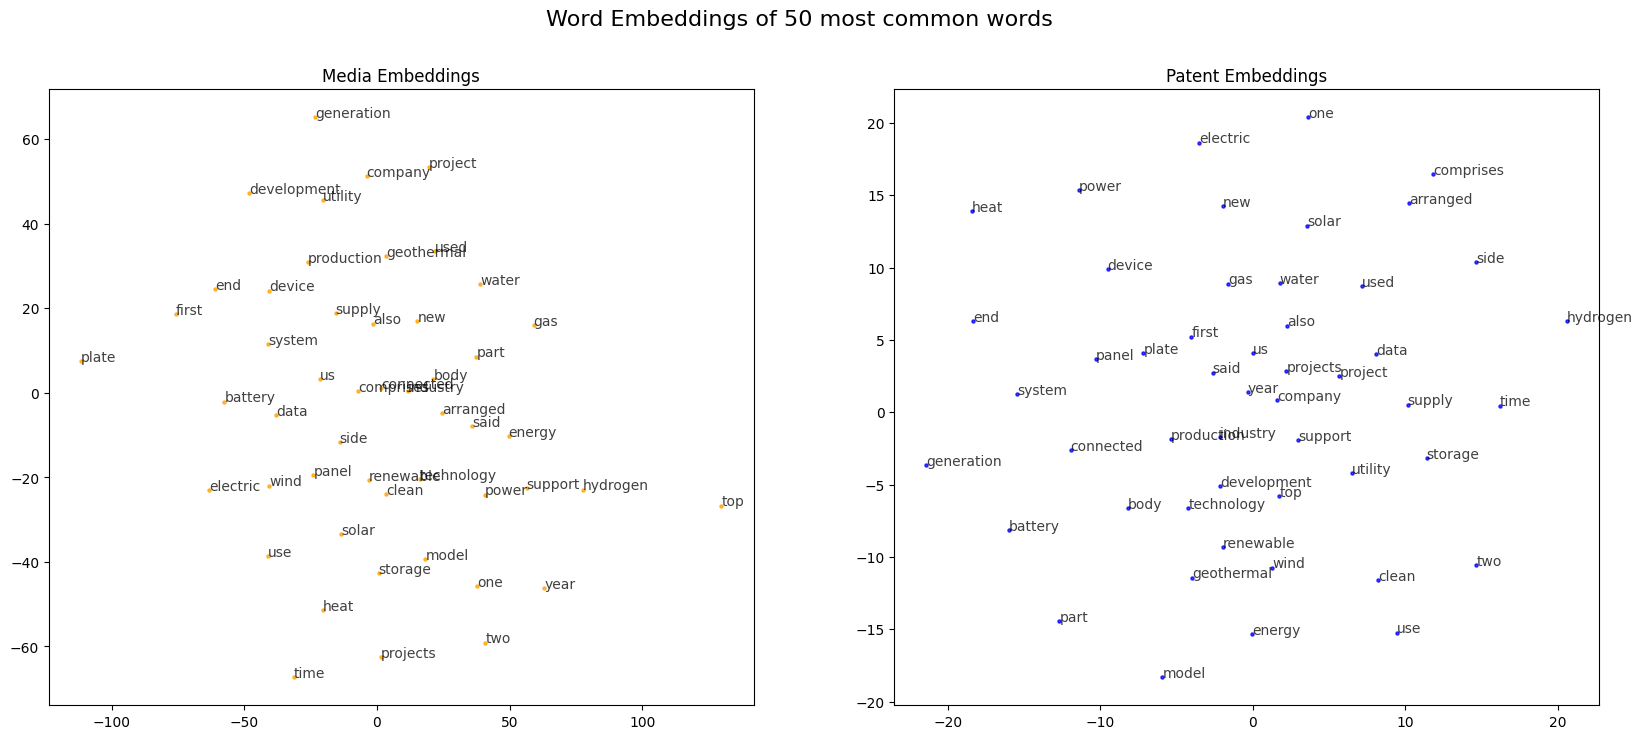

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

tsne_media = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T_media = tsne_media.fit_transform(media_word_vecs)

ax1.set_title('Media Embeddings')
ax1.scatter(T_media[:, 0], T_media[:, 1], c='Orange', alpha=0.75, s=5)
for label, x, y in zip(labels, T_media[:, 0], T_media[:, 1]):
    ax1.annotate(label,
                 xy=(x, y),
                 xytext=(0, 0),
                 alpha=0.75,
                 textcoords='offset points')

tsne_patents = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T_patents = tsne_patents.fit_transform(patent_word_vecs)

ax2.set_title('Patent Embeddings')
ax2.scatter(T_patents[:, 0], T_patents[:, 1], c='Blue', alpha=0.75, s=5)
for label, x, y in zip(labels, T_patents[:, 0], T_patents[:, 1]):
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(0, 0),
                 alpha=0.75,
                 textcoords='offset points')

plt.suptitle(f'Word Embeddings of {FREQUENCY} most common words', fontsize=16)
plt.show()

# Train with different hyperparameters

In [36]:
from tqdm import tqdm

In [47]:
%%time

hyperparams = [
    [64, 2, 5],
    [64, 5, 5],
    [64, 10, 10],
    [128, 2, 5],
    [128, 5, 5],
    [128, 10, 5],
    [256, 2, 5],
    [256, 5, 5],
    [256, 5, 10],
]

media_models = []

for [vector_size, window, epochs] in tqdm(hyperparams, ncols=100):
    media_models.append((f'{vector_size}_{window}_{epochs}', Word2Vec(sentences=media_tokens, vector_size=vector_size, window=window, epochs=epochs, seed=42)))

media_models

100%|█████████████████████████████████████████████████████████████████| 9/9 [01:46<00:00, 11.83s/it]

CPU times: user 5min 3s, sys: 1.01 s, total: 5min 4s
Wall time: 1min 46s


[('64_2_5', <gensim.models.word2vec.Word2Vec at 0x2eb9311c0>),
 ('64_5_5', <gensim.models.word2vec.Word2Vec at 0x2eb8db100>),
 ('64_10_10', <gensim.models.word2vec.Word2Vec at 0x3efda33d0>),
 ('128_2_5', <gensim.models.word2vec.Word2Vec at 0x2eb9b26a0>),
 ('128_5_5', <gensim.models.word2vec.Word2Vec at 0x3efe874c0>),
 ('128_10_5', <gensim.models.word2vec.Word2Vec at 0x3efe87820>),
 ('256_2_5', <gensim.models.word2vec.Word2Vec at 0x3efe877c0>),
 ('256_5_5', <gensim.models.word2vec.Word2Vec at 0x3efe88940>),
 ('256_5_10', <gensim.models.word2vec.Word2Vec at 0x2eb9c8e80>)]

In [48]:
%%time

patent_models = []

for [vector_size, window, epochs] in tqdm(hyperparams, ncols=100):
    patent_models.append((f'{vector_size}_{window}_{epochs}', Word2Vec(sentences=patent_tokens, vector_size=vector_size, window=window, epochs=epochs, seed=42)))

patent_models

100%|█████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.33s/it]

CPU times: user 1min 24s, sys: 324 ms, total: 1min 25s
Wall time: 30 s


[('64_2_5', <gensim.models.word2vec.Word2Vec at 0x3efe43d60>),
 ('64_5_5', <gensim.models.word2vec.Word2Vec at 0x3efe5c910>),
 ('64_10_10', <gensim.models.word2vec.Word2Vec at 0x3efe5c1f0>),
 ('128_2_5', <gensim.models.word2vec.Word2Vec at 0x17f8a0d30>),
 ('128_5_5', <gensim.models.word2vec.Word2Vec at 0x3efe88ca0>),
 ('128_10_5', <gensim.models.word2vec.Word2Vec at 0x3efe88d90>),
 ('256_2_5', <gensim.models.word2vec.Word2Vec at 0x3efe88ee0>),
 ('256_5_5', <gensim.models.word2vec.Word2Vec at 0x3efe88730>),
 ('256_5_10', <gensim.models.word2vec.Word2Vec at 0x3efe88190>)]

# Assess the embedding quality

In [49]:
# append baseline models
media_models.append(('baseline', media_embeddings_model))
patent_models.append(('baseline', patent_embeddings_model))

In [50]:
# use only the word vectors
media_models = [(model_name, model.wv) for model_name, model in media_models]
patent_models = [(model_name, model.wv) for model_name, model in patent_models]

In [51]:
# load pre-trained model for reference
import gensim.downloader as api

google_news_model = api.load("word2vec-google-news-300")

In [52]:
# include google model
media_models.append(('google-news', google_news_model))
patent_models.append(('google-news', google_news_model))

## assess similar meanings 

In this sections we look at words which have similar meaning and/or should be close together in vector space. We do this by looking at the cosine similarity between words which yields an output betweent -1 and 1. For the similar meanings we expect the values to be as large as possible (close to 1).

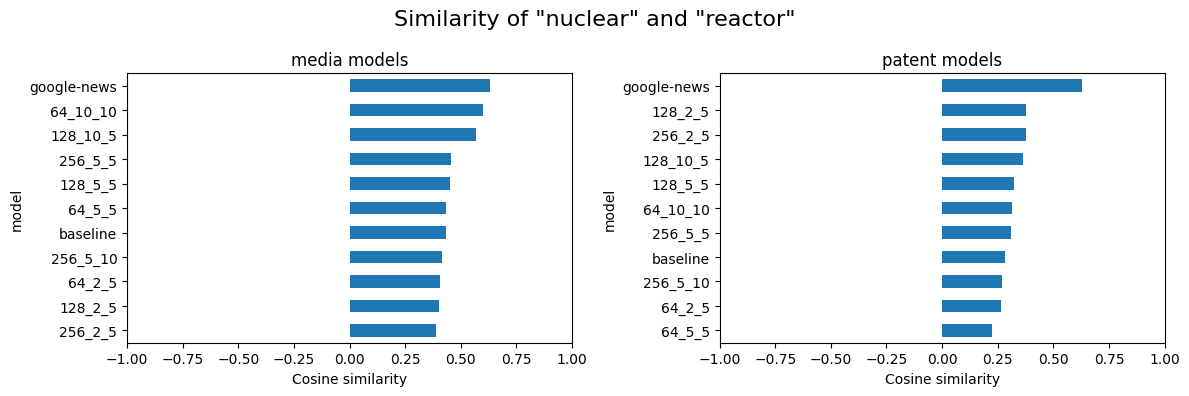

media median: 0.44
patent median: 0.31


In [111]:
# function to plot the distances
def plot_word_similarities(word_one, word_two, ascending=True): 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # media models
    df_media = pd.DataFrame([[model_name, model.similarity(word_one, word_two)] for model_name, model in media_models], 
                 columns=['model', 'similarity']).set_index('model').sort_values('similarity', ascending=ascending)
    df_media.plot(kind='barh', ax=ax1, title='media models', legend=False)
    
    # patent models
    df_patent = pd.DataFrame([[model_name, model.similarity(word_one, word_two)] for model_name, model in patent_models], 
                 columns=['model', 'similarity']).set_index('model').sort_values('similarity', ascending=ascending)
    df_patent.plot(kind='barh', ax=ax2, title='patent models', legend=False)

    ax1.set_xlabel('Cosine similarity')
    ax2.set_xlabel('Cosine similarity')
    ax1.set_xlim([-1,1])
    ax2.set_xlim([-1,1])
    
    fig.suptitle(f'Similarity of "{word_one}" and "{word_two}"', fontsize=16)
    fig.tight_layout()
    plt.show()

    print(f'media median: {df_media.similarity.median():.2f}')
    print(f'patent median: {df_patent.similarity.median():.2f}')

# first example
plot_word_similarities('nuclear', 'reactor')

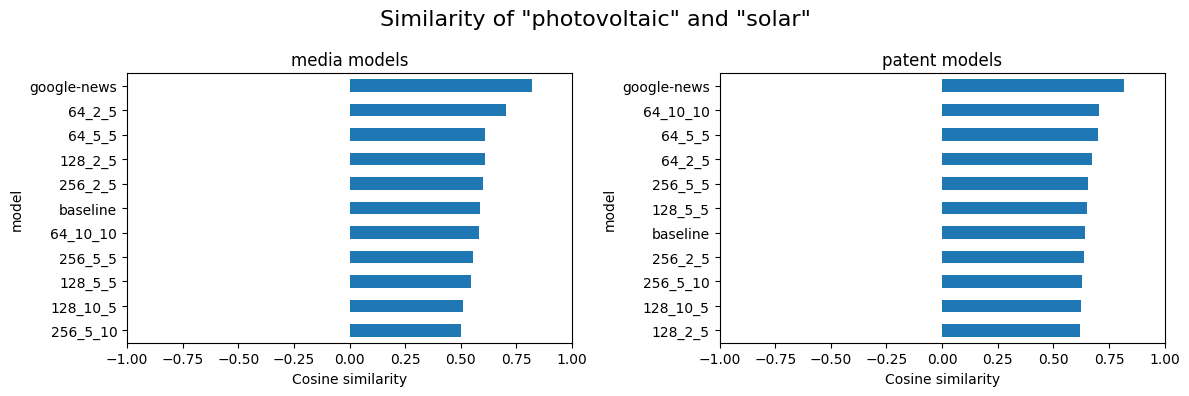

media median: 0.59
patent median: 0.65


In [112]:
plot_word_similarities('photovoltaic', 'solar')

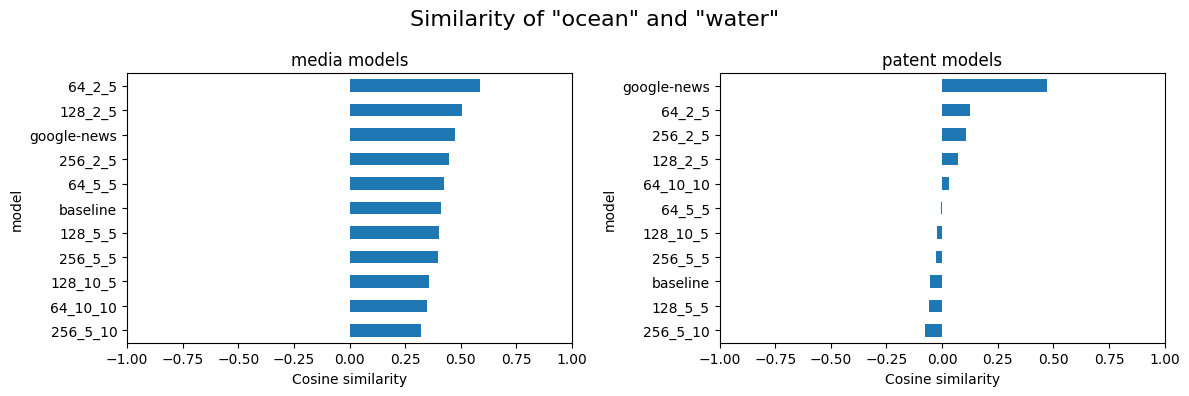

media median: 0.41
patent median: -0.01


In [113]:
plot_word_similarities('ocean', 'water')

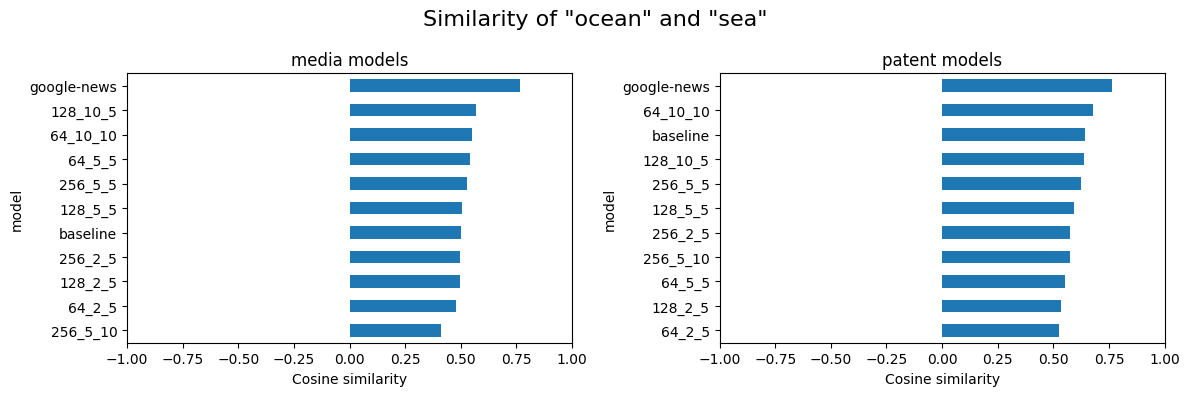

media median: 0.51
patent median: 0.59


In [114]:
plot_word_similarities('ocean', 'sea')

## Assess dissimilar meanings

When assessing dissimilar meanings, we expect negative values towards `-1`. These are words are generally antonyms - they are used with the same words (related) but have opposite meanings.

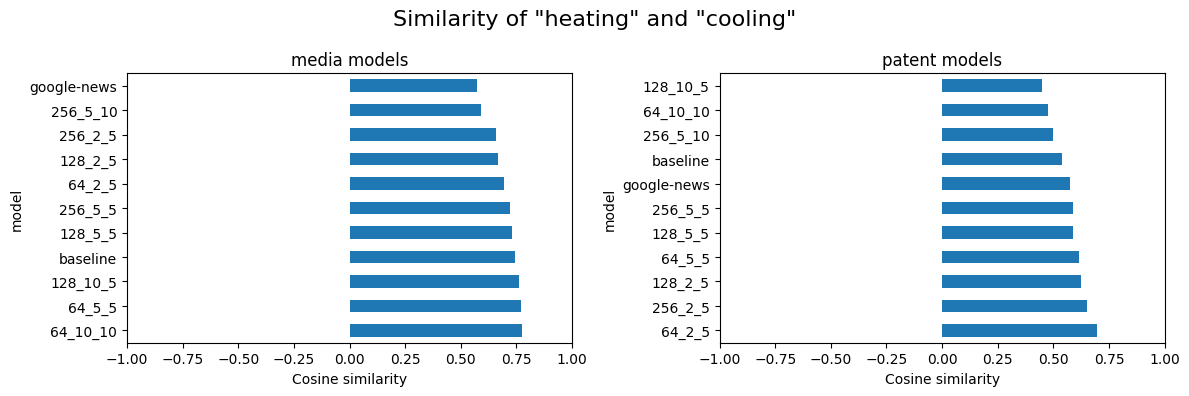

media median: 0.72
patent median: 0.59


In [115]:
plot_word_similarities('heating', 'cooling', ascending=False)

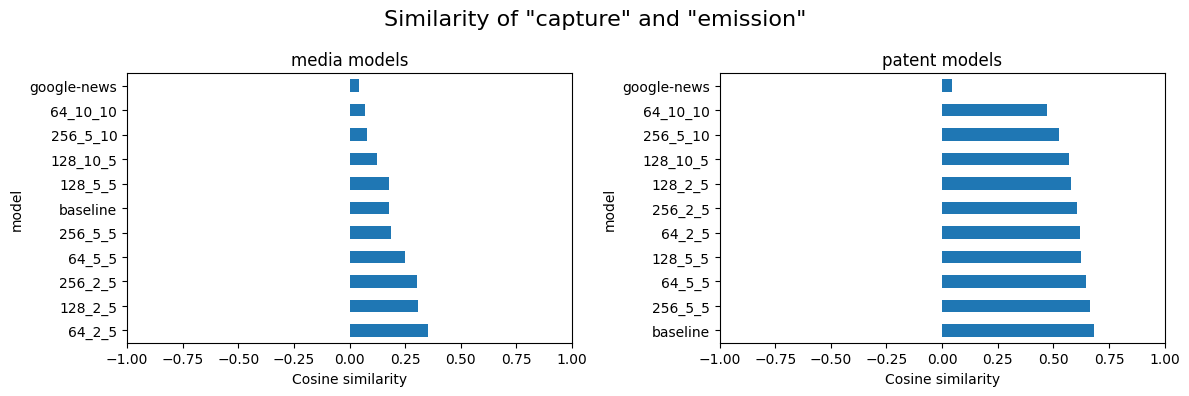

media median: 0.18
patent median: 0.61


In [116]:
plot_word_similarities('capture', 'emission', ascending=False)

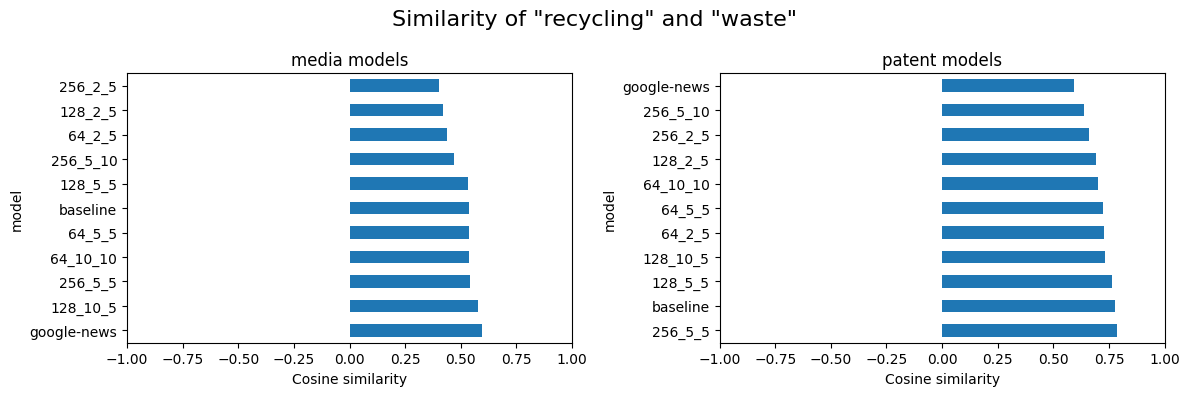

media median: 0.54
patent median: 0.72


In [125]:
plot_word_similarities('recycling', 'waste', ascending=False)

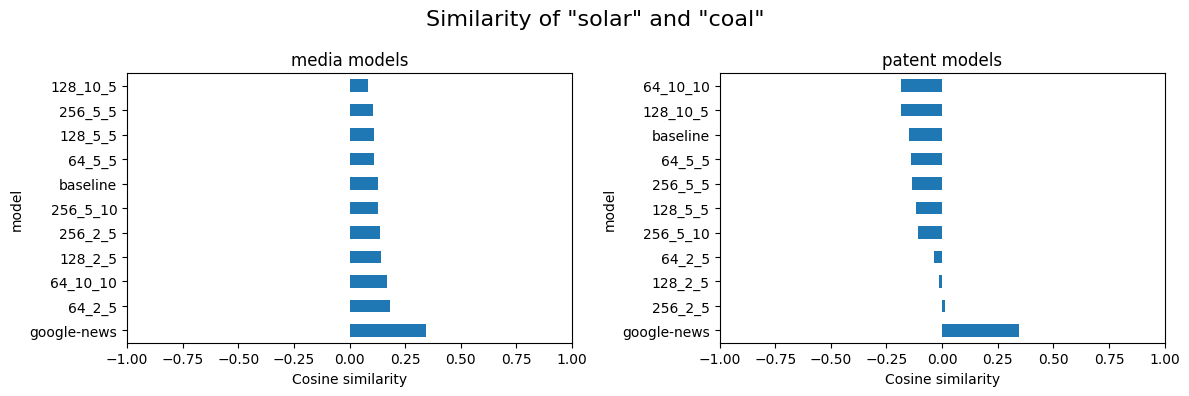

media median: 0.13
patent median: -0.12


In [119]:
plot_word_similarities('solar', 'coal', ascending=False)

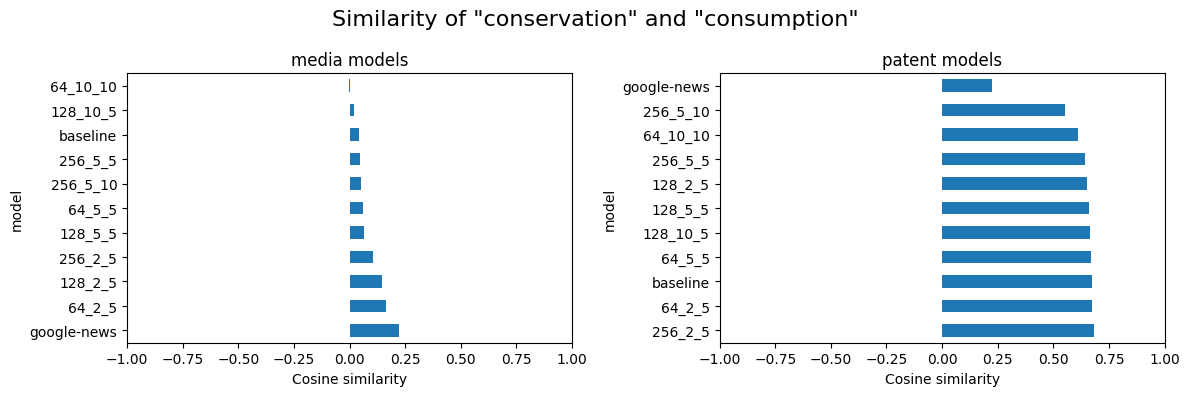

media median: 0.06
patent median: 0.66


In [120]:
plot_word_similarities('conservation', 'consumption', ascending=False)

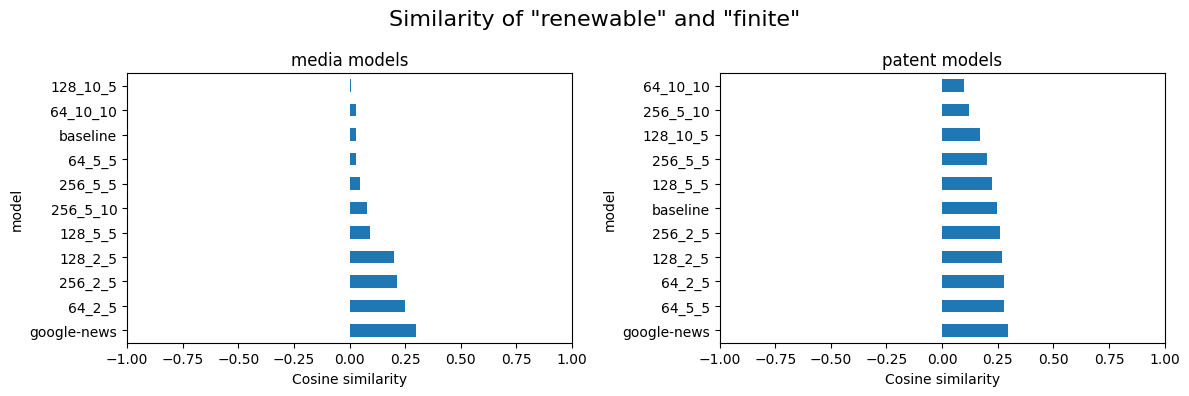

media median: 0.08
patent median: 0.25


In [121]:
plot_word_similarities('renewable', 'finite', ascending=False)

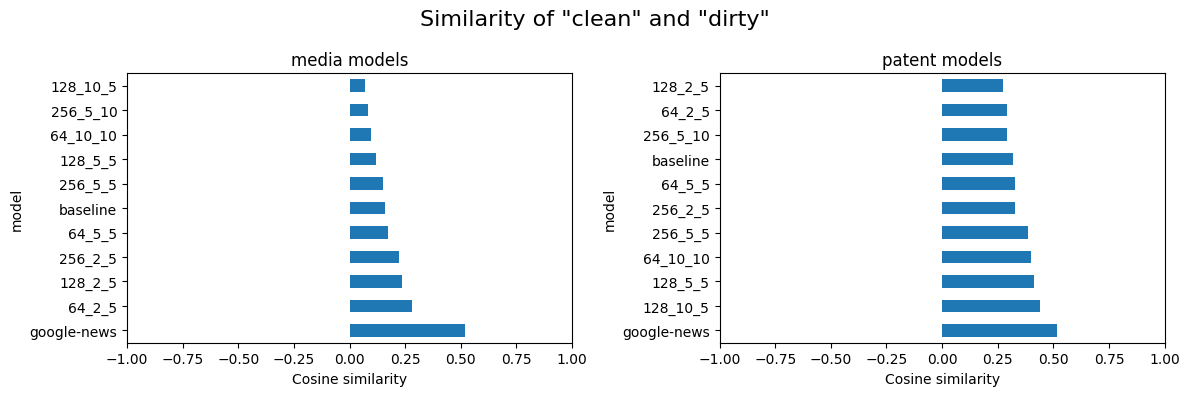

media median: 0.16
patent median: 0.33


In [122]:
plot_word_similarities('clean', 'dirty', ascending=False)

## Assess unrelated words

Unrelated words have no dimensions in commom and are orthogonal to each other - their cosine distance should be around `0`

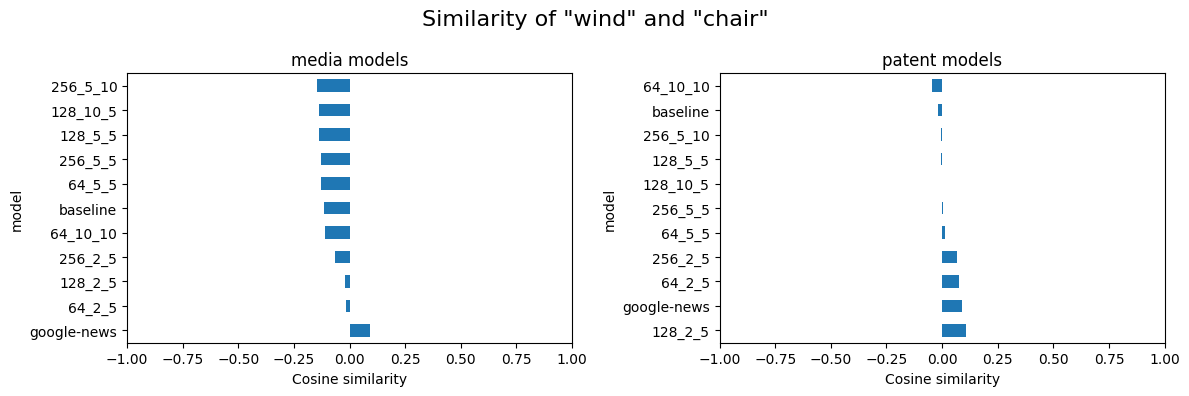

media median: -0.11
patent median: 0.01


In [124]:
plot_word_similarities('wind', 'chair', ascending=False)

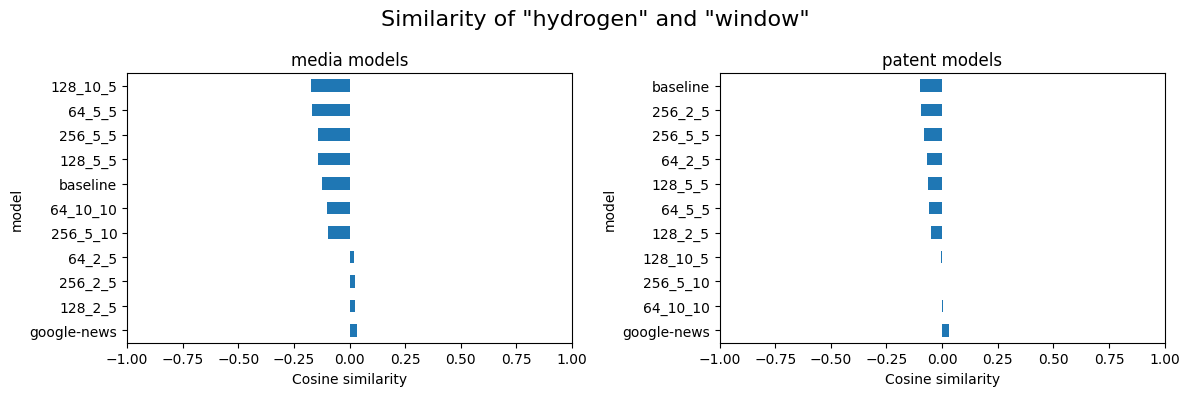

media median: -0.10
patent median: -0.06


In [127]:
plot_word_similarities('hydrogen', 'window', ascending=False)

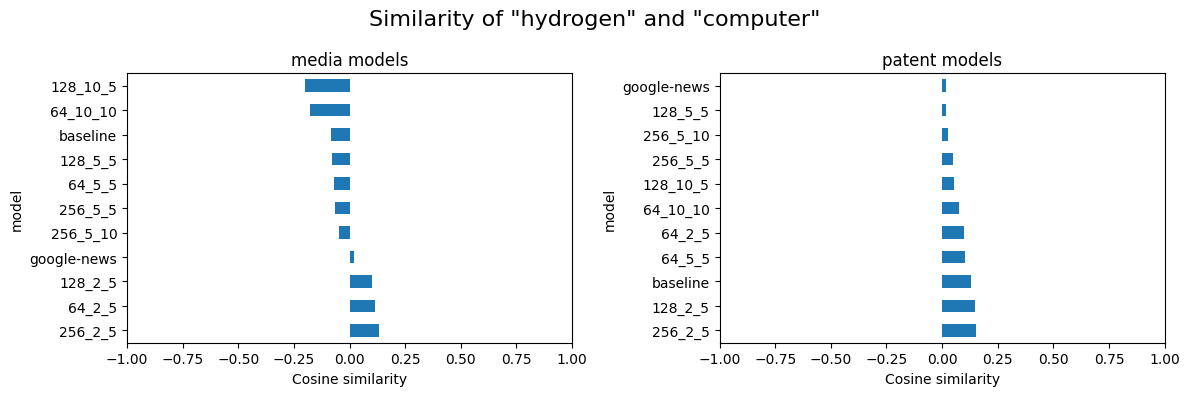

media median: -0.06
patent median: 0.08


In [132]:
plot_word_similarities('hydrogen', 'computer', ascending=False)

## Assessment by dropping words

Another way to assess our models is the `doesnt_macht()`-method: It drops the word with the largest distance to the others. Following we print the dropped words per model and our expectations:

In [167]:
TRUE_STYLE = 'color: darkgreen; background: hsl(102 37% 85% / 1);'
FALSE_STYLE = 'color: darkred; background: hsl(0deg 64.52% 87.84%);'

def drop_word(words, expected_drop='oil'):

    media_words = pd.DataFrame([{'model': model_name, 'dropped_word_media': model_vw.doesnt_match(words)}for model_name, model_vw in media_models]).set_index('model')
    patent_words = pd.DataFrame([{'model': model_name, 'dropped_word_patent': model_vw.doesnt_match(words)}for model_name, model_vw in patent_models]).set_index('model')

    df = pd.concat([media_words, patent_words], axis=1)
    
    return df.style.map(lambda x: TRUE_STYLE if x == expected_drop else FALSE_STYLE, subset=['dropped_word_media', 'dropped_word_patent'])

drop_word("solar wind hydroelectric oil".split())

,dropped_word_media,dropped_word_patent
model,,
64_2_5,oil,solar
64_5_5,oil,solar
64_10_10,oil,solar
128_2_5,oil,solar
128_5_5,oil,solar
128_10_5,oil,solar
256_2_5,oil,solar
256_5_5,oil,solar
256_5_10,oil,solar


In [168]:
drop_word("Wind Geothermal Biofuel Gasoline".lower().split(), expected_drop='gasoline')

,dropped_word_media,dropped_word_patent
model,,
64_2_5,gasoline,gasoline
64_5_5,geothermal,gasoline
64_10_10,geothermal,geothermal
128_2_5,geothermal,gasoline
128_5_5,geothermal,gasoline
128_10_5,geothermal,geothermal
256_2_5,geothermal,gasoline
256_5_5,geothermal,gasoline
256_5_10,geothermal,gasoline


In [176]:
drop_word("shell bp drilling oil wind".split(), expected_drop='wind')

,dropped_word_media,dropped_word_patent
model,,
64_2_5,wind,wind
64_5_5,wind,shell
64_10_10,wind,wind
128_2_5,wind,shell
128_5_5,wind,wind
128_10_5,wind,wind
256_2_5,wind,shell
256_5_5,wind,wind
256_5_10,wind,bp


In [178]:
drop_word("water ocean sea wave coal".split(), expected_drop='coal')

,dropped_word_media,dropped_word_patent
model,,
64_2_5,coal,water
64_5_5,coal,water
64_10_10,coal,water
128_2_5,coal,water
128_5_5,coal,water
128_10_5,coal,water
256_2_5,coal,water
256_5_5,coal,water
256_5_10,coal,water


In [179]:
## most similar words

In [ ]:
# which countries are associated with solar for example?